In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics

import os, sys
from time import time

from phm08ds.models import experiment

## Load Dataset

In [2]:
folderpath = '../../../data/interim/'
data_op_1 = pd.read_csv(folderpath + 'data_op_01.csv')
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_11,Sensor_12,Sensor_15,Operational_condition,Health_state
2,1,3,34.9986,0.8401,60.0,1368.17,1122.49,5.48,2222.86,183.26,2387.95,0.02,1,1
11,1,12,35.0029,0.8413,60.0,1360.54,1130.69,5.48,2222.88,183.41,2387.95,0.02,1,1
23,1,24,34.9987,0.8400,60.0,1359.28,1131.95,5.48,2222.88,183.36,2387.94,0.02,1,2
38,1,39,35.0010,0.8400,60.0,1370.11,1126.43,5.48,2222.88,183.45,2387.95,0.02,1,2
40,1,41,35.0018,0.8400,60.0,1359.77,1129.48,5.48,2222.89,182.97,2387.98,0.02,1,2


## Data preprocessing

### Get rid of informations there are not sensor readings

Wang (2008) reports Sensor 15 has importat information. However, there are no relevant informations of this sensor. The data seems to be corrupted like this:

Let's remove it from our database creating an object transformer.

In [3]:
from phm08ds.features.feature_selection import RemoveSensor

tf_remove_sensor_15 = RemoveSensor(sensors=[15])
data_op_1 = tf_remove_sensor_15.fit_transform(data_op_1)
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_11,Sensor_12,Operational_condition,Health_state
2,1,3,34.9986,0.8401,60.0,1368.17,1122.49,5.48,2222.86,183.26,2387.95,1,1
11,1,12,35.0029,0.8413,60.0,1360.54,1130.69,5.48,2222.88,183.41,2387.95,1,1
23,1,24,34.9987,0.8400,60.0,1359.28,1131.95,5.48,2222.88,183.36,2387.94,1,2
38,1,39,35.0010,0.8400,60.0,1370.11,1126.43,5.48,2222.88,183.45,2387.95,1,2
40,1,41,35.0018,0.8400,60.0,1359.77,1129.48,5.48,2222.89,182.97,2387.98,1,2


Before feeding to the classifier, let's remove unwanted information, such as unit, time_step and operational settings.

In [4]:
from phm08ds.features.feature_selection import RemoveInfo

tf_remove_info = RemoveInfo()

data_with_features = tf_remove_info.fit_transform(data_op_1)
data_with_features.head()

,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_11,Sensor_12,Health_state
2,1368.17,1122.49,5.48,2222.86,183.26,2387.95,1
11,1360.54,1130.69,5.48,2222.88,183.41,2387.95,1
23,1359.28,1131.95,5.48,2222.88,183.36,2387.94,2
38,1370.11,1126.43,5.48,2222.88,183.45,2387.95,2
40,1359.77,1129.48,5.48,2222.89,182.97,2387.98,2


We need to normalize our data. Let's use Z-score standardization.

In [5]:
from sklearn.preprocessing import StandardScaler

tf_std_scaller = preprocessing.StandardScaler()
data_with_features_std = tf_std_scaller.fit_transform(data_with_features.drop(labels='Health_state', axis=1))
data_with_features_std

array([[ 2.18753538e-01, -1.28328598e+00, -1.00000000e+00,
        -5.61707703e-01,  6.68924330e-01, -5.45027910e-01],
       [-1.13058311e+00, -1.71913583e-01, -1.00000000e+00,
        -4.90969556e-01,  1.06520396e+00, -5.45027910e-01],
       [-1.35340934e+00, -1.14172757e-03, -1.00000000e+00,
        -4.90969556e-01,  9.33110750e-01, -5.78004106e-01],
       ...,
       [ 8.83695318e-01,  9.06930839e-01, -1.00000000e+00,
        -1.12761287e+00, -1.10112469e+00, -1.40240900e+00],
       [ 1.05523615e+00,  9.55722798e-01, -1.00000000e+00,
        -1.26908916e+00, -1.60307888e+00, -1.13859943e+00],
       [ 2.31968661e+00,  1.83397806e+00, -1.00000000e+00,
        -1.69351804e+00, -2.58056864e+00, -1.83109955e+00]])

In [6]:
labels = np.array(data_with_features['Health_state'])
labels

array([1, 1, 2, ..., 4, 4, 4])

# Classification steps

## Load Experiment model

In [7]:
from phm08ds.models import experiment

## Define classifiers and its specifications

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [9]:
# MLP:
mlp_clf = MLPClassifier(solver='adam', learning_rate='adaptive', 
                        max_iter=2000, learning_rate_init=5e-04, tol=1e-3, hidden_layer_sizes=(100,))

## Put all clf in a dictionary:

In [10]:
classifiers = {'MLP': mlp_clf}

Since we are using SVM and MLP we need to extract all power from those methods. Let's perform a Random Search to parameters optimizations.

In [11]:
from sklearn.model_selection import cross_val_score

mlp_clf = MLPClassifier(solver='lbfgs', learning_rate='adaptive', 
                        max_iter=2000, learning_rate_init=5e-04, tol=1e-4, hidden_layer_sizes=(200,))

cross_val_score(mlp_clf, data_with_features_std, labels, cv=2, scoring='accuracy')

array([0.53848397, 0.54214057])

In [12]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='adaptive', activation='tanh',
                        max_iter=2000, learning_rate_init=5e-04, tol=1e-4, hidden_layer_sizes=(200,))

cross_val_score(mlp_clf, data_with_features_std, labels, cv=2, scoring='accuracy')

array([0.62099125, 0.62583844])

In [13]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='adaptive', 
                        max_iter=2000, learning_rate_init=5e-04, tol=1e-4, hidden_layer_sizes=(100,100))

cross_val_score(mlp_clf, data_with_features_std, labels, cv=2, scoring='accuracy')

array([0.62274052, 0.62467192])

In [14]:
mlp_clf = MLPClassifier(solver='lbfgs', learning_rate='adaptive', 
                        max_iter=2000, learning_rate_init=5e-04, tol=1e-4, hidden_layer_sizes=(100,100))

cross_val_score(mlp_clf, data_with_features_std, labels, cv=2, scoring='accuracy')

array([0.50204082, 0.51997667])

In [15]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='adaptive', 
                        max_iter=2000, learning_rate_init=5e-04, tol=1e-4, hidden_layer_sizes=(100,100,100))

cross_val_score(mlp_clf, data_with_features_std, labels, cv=2, scoring='accuracy')

array([0.62653061, 0.62292213])

In [35]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='adaptive', 
                        max_iter=2000, learning_rate_init=5e-04, tol=1e-5, 
                        hidden_layer_sizes=(200, 400, 150, 100, 50, 25))

cross_val_score(mlp_clf, data_with_features_std, labels, cv=2, scoring='accuracy')

array([0.62653061, 0.62846311])

In [36]:
import seaborn as sns

/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/navar/anaconda3/envs/phm08ds/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

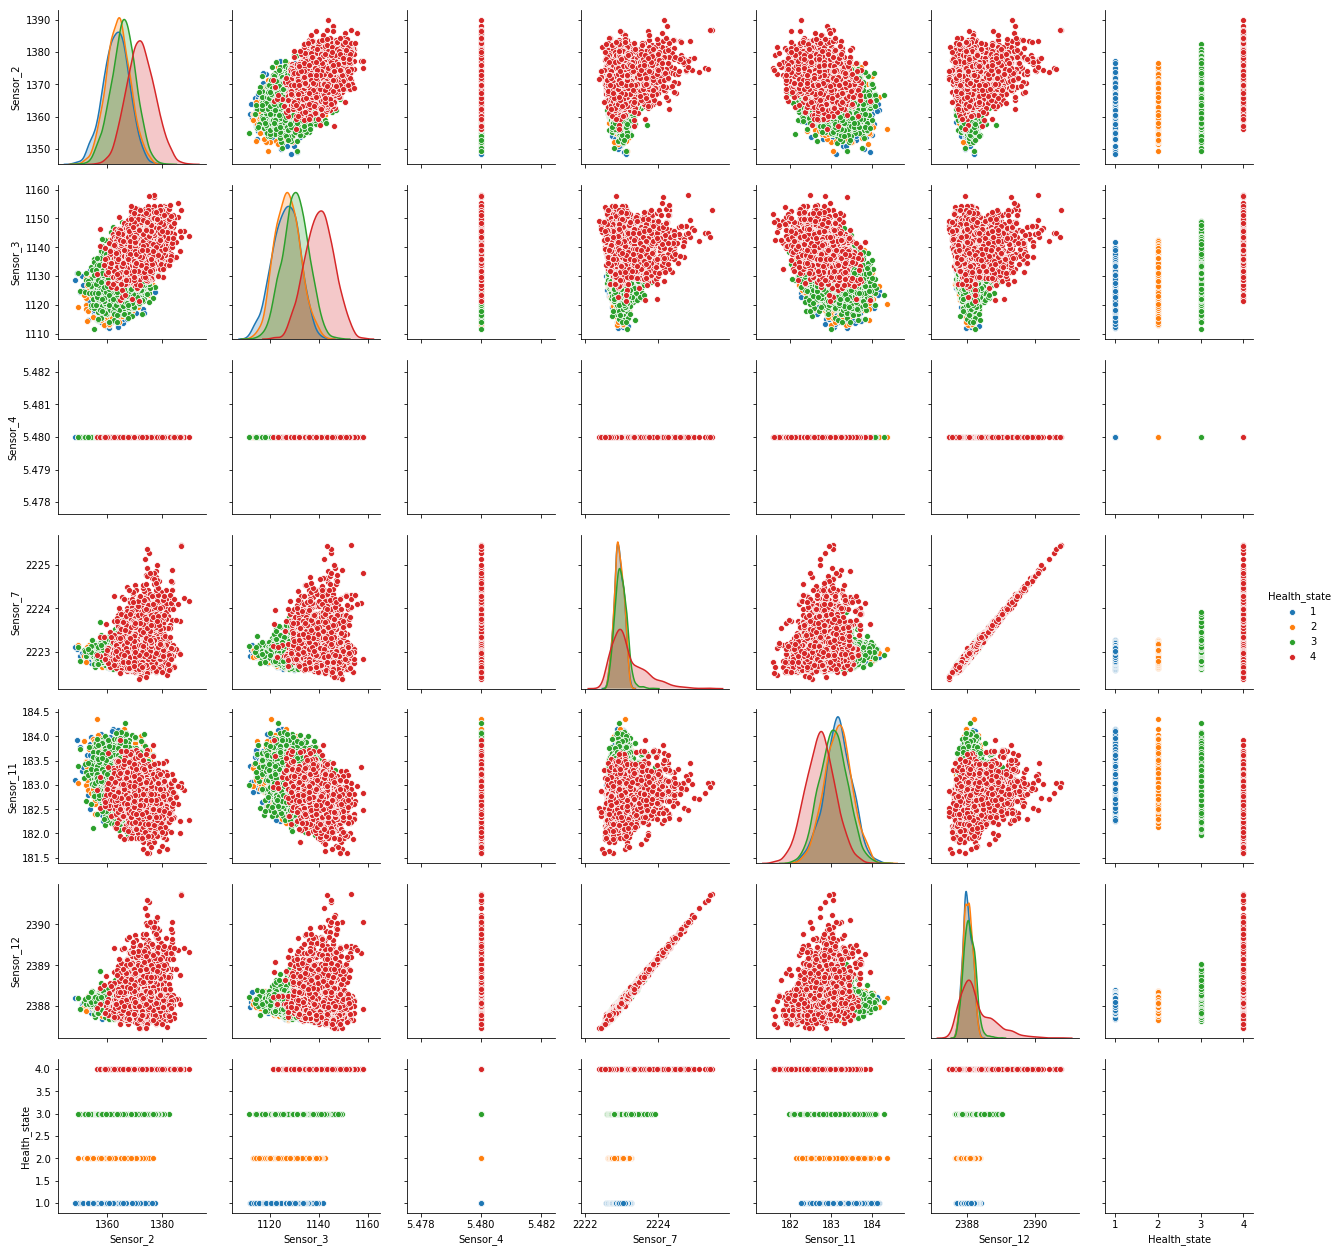

In [39]:
sns.pairplot(data_with_features, hue='Health_state')